This notebook processes all the data in *datathon_2024_dataset_corrected.csv* into a dataset that relates the outcome of each game to the team's short-term travel history preceding the game.

In [1]:
import numpy as np
import pandas as pd
from geopy.distance import distance as geodist
from tqdm import tqdm
import itertools as itr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import games dataset

df = pd.read_csv('.data/datathon_2024_dataset_corrected.csv')
df["date"] = pd.to_datetime(df["game_date"], format='%Y%m%d')
df = df[['date', 'home_team', 'away_team', 'is_day_game', 'home_score', 'away_score', 'venue_name']]
print(df.head())

        date home_team away_team  is_day_game  home_score  away_score  \
0 2000-03-29       NYN       CHN        False           3           5   
1 2000-03-30       CHN       NYN        False           1           5   
2 2000-04-03       ATL       COL         True           2           0   
3 2000-04-03       CIN       MIL         True           3           3   
4 2000-04-03       FLO       SFN        False           6           4   

         venue_name  
0        Tokyo Dome  
1        Tokyo Dome  
2      Turner Field  
3     Cinergy Field  
4  Sun Life Stadium  


In [3]:
# Import venue geolocation

venue_df = pd.read_csv('.data/venue.csv', index_col='venue_name')
print(venue_df.head())

                     lat     long
venue_name                       
Tokyo Dome        35.705  139.752
Turner Field      33.735  -84.389
Cinergy Field     39.548  -84.303
Sun Life Stadium  25.959  -80.240
Stade Olympique   45.558  -73.552


In [4]:
# Import Elo ratings

ratings_df = pd.read_csv('.data/ratings.csv', index_col=0)
print(ratings_df.head())

              NYN          CHN          ATL         CIN          FLO  \
2000  1038.017188   917.678828  1042.674724  997.844659   966.687400   
2001  1005.592796  1026.929246  1018.058941  924.181293   978.822684   
2002   987.941045   927.809848  1082.079387  977.270124   993.957073   
2003   966.341535  1029.857521  1099.373832  953.859508  1062.951834   
2004   957.956335  1039.445100  1051.894527  995.447553  1005.446032   

              MON          SLN          ANA         BAL          MIN  ...  \
2000   912.845077  1041.235203  1015.696564  967.604105   946.956321  ...   
2001   931.993227  1038.864909  1012.488507  929.048103  1026.780353  ...   
2002  1019.348446  1061.354864  1088.919223  951.939834  1034.855708  ...   
2003  1023.528184  1030.376459   972.777884  956.184437  1005.573792  ...   
2004   919.790092  1107.615123  1051.390657  984.328987  1020.424621  ...   

              SDN          SFN          BOS         DET          NYA  \
2000   969.552464  1040.555750  

In [5]:
# Get unique years

years = df['date'].dt.year.unique()
years.sort()
print(years)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [6]:
# Get unique team codes

teams = df['home_team'].unique()
teams.sort()
print(teams)

['ANA' 'ARI' 'ATL' 'BAL' 'BOS' 'CHA' 'CHN' 'CIN' 'CLE' 'COL' 'DET' 'FLO'
 'HOU' 'KCA' 'LAN' 'MIA' 'MIL' 'MIN' 'MON' 'NYA' 'NYN' 'OAK' 'PHI' 'PIT'
 'SDN' 'SEA' 'SFN' 'SLN' 'TBA' 'TEX' 'TOR' 'WAS']


In [7]:
# Reformat each game date as the number of days since the first day of the season

opening_day = {yr : df['date'][df['date'].dt.year == yr].min() for yr in years}

df['day'] = 0
for ind in tqdm(df.index):
    df.loc[ind, 'day'] = (df.loc[ind, 'date'] - opening_day[df.loc[ind, 'date'].year]).days

print(df.head())

100%|█| 56775/56775 [

        date home_team away_team  is_day_game  home_score  away_score  \
0 2000-03-29       NYN       CHN        False           3           5   
1 2000-03-30       CHN       NYN        False           1           5   
2 2000-04-03       ATL       COL         True           2           0   
3 2000-04-03       CIN       MIL         True           3           3   
4 2000-04-03       FLO       SFN        False           6           4   

         venue_name  day  
0        Tokyo Dome    0  
1        Tokyo Dome    1  
2      Turner Field    5  
3     Cinergy Field    5  
4  Sun Life Stadium    5  


In [8]:
# Compute the "home" venue of each team 

homes = pd.DataFrame(data="", index=years, columns=teams)
for ind in tqdm(df.index):
    home_team = df.loc[ind, 'home_team']
    yr = df.loc[ind, 'date'].year
    venue = df.loc[ind, 'venue_name']
    homes.loc[yr, home_team] = venue

100%|█| 56775/56775 [


In [9]:
# Create list representing days of the season
days = list(np.arange(0, df['day'].max()+1, 1))

In [10]:
'''
'location' dictionary tracks each team's location and travel for each day of each season.
'home' boolean indicates if the game is at home
'away' boolean indicates if the game is away; if both home and away are false, then the day is an off day
'travel' boolean indicates if any travel occurred since the last game
'miles_e/w' describes the number of miles traveled in the east/west direction since the last game
'daygame' boolean indicaes if the game is during the day; alternative is at night
'venue' string is the venue name
'won' boolean indicates if the game was won, if one occurred. 0.5 is a tie.
'odds' odds of the team winning based on Elo rating
'expected' expected win chance based on Elo rating
'''
location = {team:
                {year:
                    {day:
                         {'home': 0,
                          'away': 0,
                          'travel': 0,
                          'miles_e': 0,
                          'miles_w': 0,
                          'daygame': 0,
                          'venue': None,
                          'won': 0,
                          'odds': np.nan,
                          'expected': np.nan}
                     for day in [-1] + list(days) + [days[-1]+1]
                    }
                for year in years
                }
            for team in teams
            }

# Fill in the venues for when the team has off days
for team in teams:
    for yr in years:
        home_venue = homes.loc[yr, team]
        if home_venue is None:
            print(team, yr)
            del location[team][yr]
        else:
            location[team][yr][-1]['venue'] = home_venue
            location[team][yr][days[-1]+1]['venue'] = home_venue

In [11]:
# For each game in the dataset, record the travel properties and scoring
for ind in tqdm(df.index):

    # Get participants, outcome, and characteristics
    home_team = df.loc[ind, 'home_team']
    away_team = df.loc[ind, 'away_team']
    home_score = df.loc[ind, 'home_score']
    away_score = df.loc[ind, 'away_score']
    yr = df.loc[ind, 'date'].year
    day = df.loc[ind, 'day']
    daygame = df.loc[ind, 'is_day_game']
    venue = df.loc[ind, 'venue_name']
    home_rate = ratings_df.loc[yr, home_team]
    away_rate = ratings_df.loc[yr, away_team]

    # Record location and day/night
    location[home_team][yr][day]['home'] = 1
    location[away_team][yr][day]['away'] = 1    
    if daygame:
        location[home_team][yr][day]['daygame'] = 1
        location[away_team][yr][day]['daygame'] = 1
    location[home_team][yr][day]['venue'] = venue
    location[away_team][yr][day]['venue'] = venue

    # Record scoring
    if home_score == away_score:
        location[home_team][yr][day]['won'] = 0.5
        location[away_team][yr][day]['won'] = 0.5
    elif home_score > away_score:
        location[home_team][yr][day]['won'] = 1
    else:
        location[away_team][yr][day]['won'] = 1

    # Get Elo-induced odds
    location[home_team][yr][day]['odds'] = 10 ** ((home_rate - away_rate) / 400)
    location[away_team][yr][day]['odds'] = 10 ** ((away_rate - home_rate) / 400)

    # Get Elo-induced win expecations
    location[home_team][yr][day]['expected'] = 1 / (1 + 10 ** ((away_rate - home_rate) / 400))
    location[away_team][yr][day]['expected'] = 1 / (1 + 10 ** ((home_rate - away_rate) / 400))

100%|█| 56775/56775 [


In [12]:
# For each game, compute if any travel occurred from the last game

for team in teams:
    for yr in years:
        
        # Check if team stayed in venue/location
        for day in reversed(days):
            if location[team][yr][day]['venue'] is None:
                location[team][yr][day]['venue'] = location[team][yr][day+1]['venue']

        # Record distance traveled
        for day in list(days) + [days[-1]+1]:
            yesterday_venue = location[team][yr][day-1]['venue']
            today_venue = location[team][yr][day]['venue']
            if yesterday_venue != today_venue:
                location[team][yr][day]['travel'] = 1
                dist = geodist(venue_df.loc[yesterday_venue].tolist(), venue_df.loc[today_venue].tolist()).miles
                if venue_df.loc[yesterday_venue, 'long'] < venue_df.loc[today_venue, 'long']:
                    location[team][yr][day]['miles_e'] = dist
                else:
                    location[team][yr][day]['miles_w'] = dist

        # Delete entries where the team did not exist
        if sum([location[team][yr][dummy_day]['won'] for dummy_day in days]) == 0:
            del location[team][yr]

In [13]:
# Number of days in history
MAX_DELAY = 5

# Names of predictors
var_names = ['win', 'odds', 'expected'] + [f'{var}{delay}' for var, delay in itr.product(['home', 'away', 'daygame', 'travel', 'miles_e', 'miles_w'], range(MAX_DELAY))]

# Name of each game
ind_names = []
for team in teams:
    for yr in location[team].keys():
        for day in days:
            ind_names.append(f'{team}{yr}{day}')

In [14]:
# Fill in game data into a dictionary for putting into a dataframe
ml_dict = {ind: {} for ind in ind_names}
for team in tqdm(teams):
    for yr in location[team].keys():
        for day in days:
            ind = f'{team}{yr}{day}'
            ml_dict[ind]['won'] = location[team][yr][day]['won']
            ml_dict[ind]['odds'] = location[team][yr][day]['odds']
            ml_dict[ind]['expected'] = location[team][yr][day]['expected']
            for delay_day in range(day, min(day + MAX_DELAY, days[-1]+1)):
                delay_ind = f'{team}{yr}{delay_day}'
                for var in ['home', 'away', 'daygame', 'travel', 'miles_e', 'miles_w']:
                    var_name = f'{var}{delay_day-day}'
                    ml_dict[delay_ind][var_name] = location[team][yr][day][var]
ml_df = pd.DataFrame(ml_dict).transpose()
ml_df = ml_df.dropna()
print(ml_df.iloc[:20, ])
print(ml_df.shape)

100%|█| 32/32 [00:06<


           won      odds  expected  home0  away0  daygame0  travel0  \
ANA20005   0.0  0.911570  0.476870    1.0    0.0       0.0      0.0   
ANA20006   0.0  0.911570  0.476870    1.0    0.0       0.0      0.0   
ANA20007   1.0  0.911570  0.476870    1.0    0.0       0.0      0.0   
ANA20009   1.0  0.910219  0.476500    1.0    0.0       0.0      0.0   
ANA200010  1.0  0.910219  0.476500    1.0    0.0       0.0      0.0   
ANA200011  0.0  0.910219  0.476500    1.0    0.0       1.0      0.0   
ANA200012  1.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200013  1.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200014  0.0  1.060365  0.514649    1.0    0.0       0.0      0.0   
ANA200016  0.0  0.775286  0.436711    0.0    1.0       0.0      0.0   
ANA200017  1.0  0.775286  0.436711    0.0    1.0       1.0      0.0   
ANA200018  1.0  0.775286  0.436711    0.0    1.0       1.0      0.0   
ANA200019  0.0  1.060365  0.514649    0.0    1.0       0.0      1.0   
ANA200

In [15]:
# Write to CSV
ml_df.to_csv('.data/logregression_data.csv')

C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\georg\OneDrive\Documents\Rice University\Projects\Datathon 2024\MLB-Schedule-Morale\.venv_datathon2024\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, 

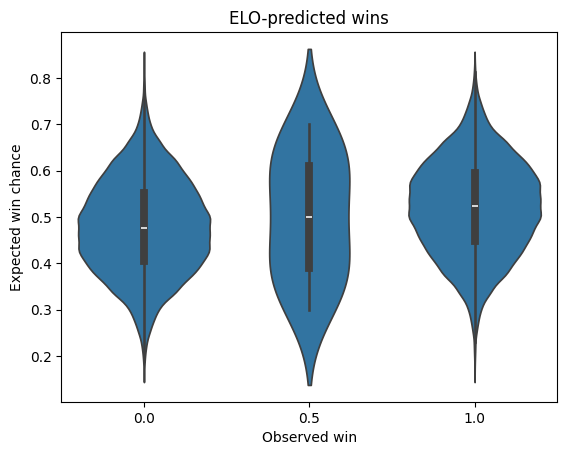

In [16]:
# Visualize efficacy of Elo expecations as predictors
sns.violinplot(x=ml_df['won'].astype(float), y=ml_df['expected'])
plt.xlabel('Observed win')
plt.ylabel('Expected win chance')
plt.title('ELO-predicted wins')
plt.show()